In [1]:
from boututils.datafile import DataFile
from boutdata.collect import collect
from boutdata.data import BoutData
import os, sys
import matplotlib

import matplotlib.pyplot as plt
import xbout
import pandas as pd
import numpy as np
import xarray as xr

from boutdata.restart import addvar
import glob
import shutil
import scipy

sys.path.append(r"/home/mike/work/sdtools")


from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.neutral_transport import NeutralTransport
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *
from hermes3.utils import *
from hermes3.balance1d import *
# from code_comparison.code_comparison import *

%load_ext autoreload
%autoreload 2

## Read Hermes-3

In [7]:
db = CaseDB(
    case_dir = r"/home/mike/work/cases",
    grid_dir = r"/home/mike/work/cases"
)

toload = [ 
    dict(name="base", id="st40_2Dtest_base", unnormalise_geom = True, use_xhermes = True, squash = True), 
    dict(name="test", id="st40_2Dtest_1", unnormalise_geom = True, use_xhermes = True, squash = True), 
    dict(name="test_change", id="st40_2Dtest_change", unnormalise_geom = True, use_xhermes = True, squash = True), 
]
cs = {}
for case in toload:
    cs[case["name"]] = db.load_case_2D(case["id"], use_squash = case["squash"], verbose = True)
    cs[case["name"]].ds = cs[case["name"]].ds.hermes.extract_2d_tokamak_geometry()


/home/mike/work/boutdata/src/boutdata/data.py:761: AlwaysWarning: While building x, y, z coordinate arrays, an exception occured: [Errno 2] No such file or directory: '"grid_test2.nc"'
Evaluating non-scalar options not available
  alwayswarn(


- Reading case st40_2Dtest_base
-----------------------
- Looking for squash file
- Squash file found. squash date 01/19/2026, 10:50:22, dmp file date 01/19/2026, 10:15:07


/home/mike/work/xbout/xbout/load.py:1129: UserWarning: Will drop all variables containing the dimensions 't' because they are not recognised
  warn(



Unnormalising with xHermes
- Reading case st40_2Dtest_1
-----------------------
- Looking for squash file
- Squash file found. squash date 01/19/2026, 10:50:20, dmp file date 01/19/2026, 10:43:42


/home/mike/work/boutdata/src/boutdata/data.py:761: AlwaysWarning: While building x, y, z coordinate arrays, an exception occured: [Errno 2] No such file or directory: '"grid_test2.nc"'
Evaluating non-scalar options not available
  alwayswarn(
/home/mike/work/xbout/xbout/load.py:1129: UserWarning: Will drop all variables containing the dimensions 't' because they are not recognised
  warn(



Unnormalising with xHermes
- Reading case st40_2Dtest_change
-----------------------
- Looking for squash file
- Squash file found. squash date 01/19/2026, 10:52:17, dmp file date 01/19/2026, 10:51:23


/home/mike/work/boutdata/src/boutdata/data.py:761: AlwaysWarning: While building x, y, z coordinate arrays, an exception occured: [Errno 2] No such file or directory: '"grid_test2.nc"'
Evaluating non-scalar options not available
  alwayswarn(
/home/mike/work/xbout/xbout/load.py:1129: UserWarning: Will drop all variables containing the dimensions 't' because they are not recognised
  warn(



Unnormalising with xHermes


In [54]:
expected = {}

In [55]:
expected["inner_lower_target"] = {}
expected["inner_lower_target"]["Pe"] = [1.5408606616749976, 1.5408606616749978, 1.7824050188191767, 2.437237002789983, 3.5684583060575155, 5.468312901016866, 8.699878597367771, 14.316688383093245, 24.73504287279548, 48.631073044357244, 125.36399778927616, 86.0387898879148, 44.27529365545349, 22.327397206348028, 9.737901698676854, 3.8278649403794285, 1.292881611846243, 0.3746342822708637, 0.1528401632146173, 0.1528401632146174]
expected["inner_lower_target"]["NVd+"] = [0.0, 0.00016913688560189476, -0.00019565067839200187, -0.00027899443660062286, -0.0003995032238660135, -0.0005878970540362951, -0.0008781442651622576, -0.0013198675832196422, -0.0019881703117261727, -0.0029983882777155813, -0.004399717579895961, -0.003192387460987224, -0.002070866128552988, -0.001308241661806786, -0.0007365353251739455, -0.0003535057686097485, -0.00014573911466599562, -5.1742441443045875e-05, 2.110944878653718e-05, 0.0]

expected["inner_upper_target"] = {}
expected["inner_upper_target"]["Pe"] = [1.5943634392807884, 1.5943634392807877, 1.846799800583734, 2.528449083763007, 3.6882639791973135, 5.624953689092742, 8.900641615786546, 14.564018144486006, 25.00371154369332, 48.909533802545354, 125.9911463611046, 86.31330017820727, 44.316710620494966, 22.305621378891566, 9.741738715124646, 3.835413531050889, 1.2959001906615233, 0.37305409346065244, 0.15189468579947948, 0.1518946857994795]
expected["inner_upper_target"]["NVd+"] = [0.0, -0.00017341936274556355, 0.00020087693724357984, 0.0002884071878003277, 0.0004120123090572419, 0.0006040551243779636, 0.000899871817959208, 0.0013465060287952213, 0.002018090821440274, 0.0030318274715743342, 0.004445950523366812, 0.003212990814151414, 0.0020783069521725893, 0.0013105121288937312, 0.0007380954155835657, 0.0003547179079283025, 0.00014627333193385005, 5.1511030388470286e-05, -2.0973504682610834e-05, 0.0]

expected["outer_upper_target"] = {}
expected["outer_upper_target"]["Pe"] = [1.2776092277886315, 1.2776092277886317, 1.3494075227152744, 1.792405662849659, 2.664249677165807, 4.3049566544305815, 7.415583174867959, 13.624317507911428, 26.917379001307257, 56.18188282119928, 110.87319074087011, 114.40594281982686, 72.25927274960144, 33.84178056745299, 13.906285515995407, 4.779777725182298, 1.4338519785173305, 0.4080509006615387, 0.1732216804890877, 0.17322168048908762]
expected["outer_upper_target"]["NVd+"] = [0.0, 0.00013588521826553561, -0.00014352161190217758, -0.0002012676510521716, -0.00028185917822087385, -0.0004163461552273397, -0.0006376690511897239, -0.0010001990253455822, -0.0015876810895051874, -0.002508257735675564, -0.0037024640446927646, -0.003880665342768093, -0.002990446475307072, -0.0018907378799296552, -0.0010330188701905135, -0.00044739168887878453, -0.00015984852314078092, -5.331708343666143e-05, 2.2633634129228408e-05, 0.0]

expected["outer_lower_target"] = {}
expected["outer_lower_target"]["Pe"] = [1.2193085630076228, 1.2193085630076226, 1.2897250240122111, 1.7220278500675517, 2.574631589107167, 4.181024655243739, 7.233979560871374, 13.35097466265149, 26.533281270506958, 55.83030858250879, 111.49403159834175, 114.62403663195718, 72.07617227842323, 33.73730254515277, 13.913229813782014, 4.7906587066946935, 1.4422857876550566, 0.41054887042637533, 0.17269749002898055, 0.17269749002898052]
expected["outer_lower_target"]["NVd+"] = [0.0, -0.0001309936720064361, 0.00013855870605650156, 0.00019545836466546351, 0.0002754622345271687, 0.0004090259894521283, 0.0006294071237496496, 0.0009919663840085816, 0.0015830654308245677, 0.002514418802244024, 0.003725867960237438, 0.0038905991555969865, 0.0029813959789778558, 0.0018843466511763896, 0.0010328788284466178, 0.000448817661644576, 0.0001611441352996859, 5.378610214129262e-05, -2.2625137973456876e-05, 7.26983086785536e-21]

expected["outer_midplane_a"] = {}
expected["outer_midplane_a"]["Pe"] = [11102.273859149962, 17452.629658584417, 17452.629658584417, 11102.273859149966, 6959.693774966975, 4249.810252647301, 2512.048384074001, 1439.6725700877194, 807.5696679840765, 435.1066888638418, 167.1358858313969, 127.73216945043275, 88.37331523282191, 53.77433039855373, 27.85666830659451, 12.108679802876827, 4.330083078619639, 1.3682824008642205, 0.8779375055779194, 0.8779375055779198]
expected["outer_midplane_a"]["NVd+"] = [0.0, -1.418905454169041e-06, 1.418905454169041e-06, 3.480249097939277e-07, 9.752284001970606e-07, 2.889309463717777e-06, 7.142609322696786e-06, 1.6100557537953165e-05, 2.752624287437304e-05, 2.377238565263189e-05, 1.7730905289665668e-05, 1.6662443549658734e-05, 2.202583759386625e-05, 1.0323884702543356e-05, -1.1379589893701264e-05, -1.7530089157790424e-05, -1.1925604180757179e-05, -6.023273477296812e-06, 3.864741436951624e-06, 0.0]

expected["sol_boundary"] = {}
expected["sol_boundary"]["Pe"] = [0.43720670469802264, 0.32101713890582967, 0.3746342822708637, 0.43720670469802264, 0.48516439844318054, 0.5248342456384424, 0.5782137267713892, 0.6686686389364611, 0.759428991339635, 0.8122654996579911, 0.847653319725188, 0.8628824751226055, 0.8633000181896054, 0.8483446892960866, 0.8122194386544012, 0.7579290386583684, 0.6654377190709245, 0.5741895991373285, 0.5210548397667165, 0.48211229045893345, 0.43491626725813315, 0.37305409346065244, 0.3199911503083625, 0.43491626725813304, 0.5262079863001237, 0.31642533345308493, 0.4080509006615387, 0.5262079863001236, 0.6112946929078317, 0.6867952813683194, 0.7554827878131483, 0.8249781644385169, 0.8996263726097232, 0.9765458076250555, 1.0397559239287775, 1.1011927393016832, 1.1939560851628184, 1.2814950389023894, 1.3322534987285903, 1.356530829214683, 1.3682824008642205, 1.3681062462369176, 1.3552116363376634, 1.3289125567207163, 1.2758114472739233, 1.1861981234932666, 1.0924326296214735, 1.0307095804944195, 0.9682302628481749, 0.8924456439327408, 0.8189988183965965, 0.7508517120556226, 0.6837961635646481, 0.6101202740989534, 0.5268976015473682, 0.41054887042637533, 0.319892090063386, 0.5268976015473681]
expected["sol_boundary"]["NVd+"] = [0.0, -5.4519838680863315e-05, -5.1742441443045875e-05, -5.1452811861455865e-05, -5.004416493696635e-05, -4.888376096080437e-05, -4.6008225814278786e-05, -4.0900177964378346e-05, -3.672708850202474e-05, -2.8068363067458015e-05, -1.8187024038898192e-05, -6.320852762288727e-06, 6.077909871952881e-06, 1.794426052676907e-05, 2.785684527370884e-05, 3.658240803603152e-05, 4.078110721265273e-05, 4.590072280691015e-05, 4.8741111020929625e-05, 4.9866526334975786e-05, 5.1236525403485925e-05, 5.1511030388470286e-05, 5.426269361757493e-05, 0.0, 0.0, -5.7274509313839314e-05, -5.331708343666143e-05, -5.529256804485429e-05, -5.411415369427673e-05, -5.344961786126515e-05, -5.250728284542564e-05, -5.152304741023295e-05, -5.0153528603313674e-05, -4.87044778952785e-05, -4.787396620890973e-05, -4.589823631733452e-05, -4.182225517962598e-05, -3.7245080622682704e-05, -2.9280852310961656e-05, -1.8117714858305085e-05, -6.023273477296812e-06, 6.732215881235471e-06, 1.8895723087104158e-05, 3.0113153292731808e-05, 3.811460804198358e-05, 4.265499643807905e-05, 4.665350026862134e-05, 4.861749134082548e-05, 4.941090002755489e-05, 5.080454768657361e-05, 5.212790672850831e-05, 5.3072213536471264e-05, 5.397971675536448e-05, 5.460570347160693e-05, 5.575619663008118e-05, 5.378610214129262e-05, 5.7711132545227795e-05, 7.26983086785536e-21]

expected["core_and_pfr_boundary"] = {}
expected["core_and_pfr_boundary"]["Pe"] = [2.10510551641715, 1.127853953249072, 1.5408606616749976, 2.1051055164171504, 2.4260925252776078, 2.424796161264651, 2.248202542526519, 11102.210320567308, 11102.21739759535, 11102.23719602184, 11102.250563333704, 11102.260938750402, 11102.264698949384, 11102.234659552338, 11102.252157862436, 11102.212890538509, 11102.211369419432, 2.3368395332414096, 2.5159261516111973, 2.5154522790956597, 2.1804739836740064, 1.5943634392807884, 1.1657991774027543, 2.1804739836740064, 1.8599336825820658, 0.8776040534222876, 1.2776092277886315, 1.8599336825820663, 2.1688176502849292, 2.374865478687732, 2.5104976700272488, 2.59527490606937, 2.633374168863429, 2.60131699544898, 2.440704244451776, 2.265181141660266, 11102.197650734539, 11102.176563916579, 11102.25255910037, 11102.1661173468, 11102.273859149962, 11102.274402516816, 11102.166117447257, 11102.253790556551, 11102.177541353532, 11102.1991113175, 2.175050709233424, 2.336997635278462, 2.487025049656688, 2.516314781761756, 2.478341047925842, 2.3967487320726986, 2.2663267360729913, 2.069022972706463, 1.7734969514722283, 1.2193085630076228, 0.8382948561538556, 1.7734969514722283]
expected["core_and_pfr_boundary"]["NVd+"] = [0.0, -0.0003935281098789662, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0004046174559656422, 0.0, 0.0, -0.00031736024835691846, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.63491543392768e-21, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -3.63491543392768e-21, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00030551505620125103, 0.0]

expected["sol_ring"] = {}
expected["sol_ring"]["Pe"] = [142.3624772215049, 110.395184520824, 125.36399778927616, 142.36247722150486, 141.86511365292213, 139.92294805311585, 135.72354024043662, 125.64406032881237, 121.66301597776987, 120.44760571530536, 120.60676483159628, 120.33620552740189, 120.32930513028721, 120.59309673314286, 120.42743503751642, 121.6606626701388, 125.66970868473666, 135.79777903980641, 140.08625942455657, 142.10656264244793, 142.64072936784478, 125.9911463611046, 111.28496770687205, 142.64072936784476, 142.05462665117955, 86.5361777708723, 110.87319074087011, 142.05462665117955, 148.63503201347936, 151.53428234327495, 151.94343988261423, 151.40692260383543, 152.89465047123417, 154.74585418827238, 157.69123237393646, 162.44743676782934, 159.72808950724777, 164.67137782401835, 166.56182760578662, 167.0413165578113, 167.1358858313969, 167.14367016818468, 167.06010047013612, 166.6302476716631, 164.82267434986898, 160.0827310300723, 162.94173523531646, 158.28208105864707, 155.40368667877502, 153.52166543737275, 152.08647041857728, 152.49714420550072, 152.1352421323277, 149.250862288958, 142.62934685257795, 111.49403159834175, 87.15540915223185, 142.62934685257795]
expected["sol_ring"]["NVd+"] = [0.0, -0.009396429494879918, -0.004399717579895961, -0.0033768276123468544, -0.0022314451387572577, -0.0013343352572906379, -0.00042719970411667313, 0.00015564815581385808, 0.00027061437256047885, 0.00023045836035926154, 0.00013842218817094042, 4.5005320538132116e-05, -5.4881379554093855e-05, -0.0001473207275896947, -0.00023837244254771566, -0.00027818091987608876, -0.00016215982771800296, 0.0004214775540889335, 0.0013300908678211263, 0.002240167084673976, 0.0034105356646905727, 0.004445950523366812, 0.0095039666869772, 0.0, 0.0, -0.007060994960880689, -0.0037024640446927646, -0.003069862308405074, -0.0023003960511846647, -0.0019238118149361005, -0.0016847265493368313, -0.0015525127355871201, -0.0015344250346749969, -0.001563754168898026, -0.0014771110457528897, -0.0010032101968176228, -0.0005162559104570271, -0.00013584000314758595, 3.685085066921282e-05, 4.433676782875308e-05, 1.7730905289665668e-05, -2.387696837261221e-05, -5.0763325665944395e-05, -4.373099886146068e-05, 0.00012770989328351367, 0.0005018452209404757, 0.0009912396839352115, 0.0014609180377266706, 0.0015437558202554044, 0.0015198964981504174, 0.0015532715900317005, 0.0016918699141317644, 0.0019400852144926843, 0.002321600055344312, 0.0030921726499161775, 0.003725867960237438, 0.007103748204194814, 0.0]

In [57]:
gen_data = False
rtol = 1e-6
atol = 1e-8

ds = cs["test_change"].ds.isel(t=-1)
m = ds.metadata


# Testing at specific locations around the domain
x_selection = slice(None)
regions = {}
regions["inner_lower_target"] = ds.isel(x = x_selection, theta = 2)
regions["inner_upper_target"] = ds.isel(x = x_selection, theta = m["ny_innerg"] - m["MYG"] * 2 -1)
regions["outer_upper_target"] = ds.isel(x = x_selection, theta = m["ny_innerg"])
regions["outer_lower_target"] = ds.isel(x = x_selection, theta = -3)
regions["outer_midplane_a"] = ds.isel(x = x_selection, theta = int((m["jyseps2_2g"] - m["jyseps1_2g"]) / 2) + m["jyseps1_2g"])
regions["sol_boundary"] = ds.isel(x = -3, theta = slice(None))
regions["core_and_pfr_boundary"] = ds.isel(x = 0, theta = slice(None))
regions["sol_ring"] = ds.isel(x = m["ixseps1"], theta = slice(None))

if gen_data: 

    # Generate test data, print to console and fail test
    for region_name, ds in regions.items():
        print(f'expected["{region_name}"] = {{}}')
        print(f'expected["{region_name}"]["Pe"] = {ds["Pe"].values.tolist()}')
        print(f'expected["{region_name}"]["NVd+"] = {ds["NVd+"].values.tolist()}')
        print("")

    success = False
else:

    # Perform test
    failures = []
    for region_name, ds in regions.items():

        for variable in ["Pe", "NVd+"]:

            actual = ds[variable]
            reference = expected[region_name][variable]

            try:
                np.testing.assert_allclose(actual, reference, rtol=rtol, atol=atol)
            except AssertionError as e:
                failures.append({
                    "region": region_name,
                    "variable": variable,
                    "error_msg": str(e)
                })
    
    if failures:
        print("FAILURES:")
        for f in failures:
            print(f"\n{f['region']} [{f['variable']}]:")
            print(f["error_msg"])
    else:
        print("All tests passed!")

FAILURES:

inner_lower_target [Pe]:

Not equal to tolerance rtol=1e-06, atol=1e-08

Mismatched elements: 5 / 20 (25%)
Max absolute difference among violations: 0.00552922
Max relative difference among violations: 0.00310211
 ACTUAL: array([  1.536081,   1.536081,   1.776876,   2.436971,   3.568447,
         5.468312,   8.699878,  14.316688,  24.735043,  48.631072,
       125.363996,  86.038788,  44.275293,  22.327397,   9.737902,
         3.827865,   1.292882,   0.374634,   0.15284 ,   0.15284 ])
 DESIRED: array([  1.540861,   1.540861,   1.782405,   2.437237,   3.568458,
         5.468313,   8.699879,  14.316688,  24.735043,  48.631073,
       125.363998,  86.03879 ,  44.275294,  22.327397,   9.737902,
         3.827865,   1.292882,   0.374634,   0.15284 ,   0.15284 ])

inner_upper_target [Pe]:

Not equal to tolerance rtol=1e-06, atol=1e-08

Mismatched elements: 5 / 20 (25%)
Max absolute difference among violations: 0.00569413
Max relative difference among violations: 0.00308324
 ACTU

In [38]:
np.argmax(diff.values)

np.int64(0)

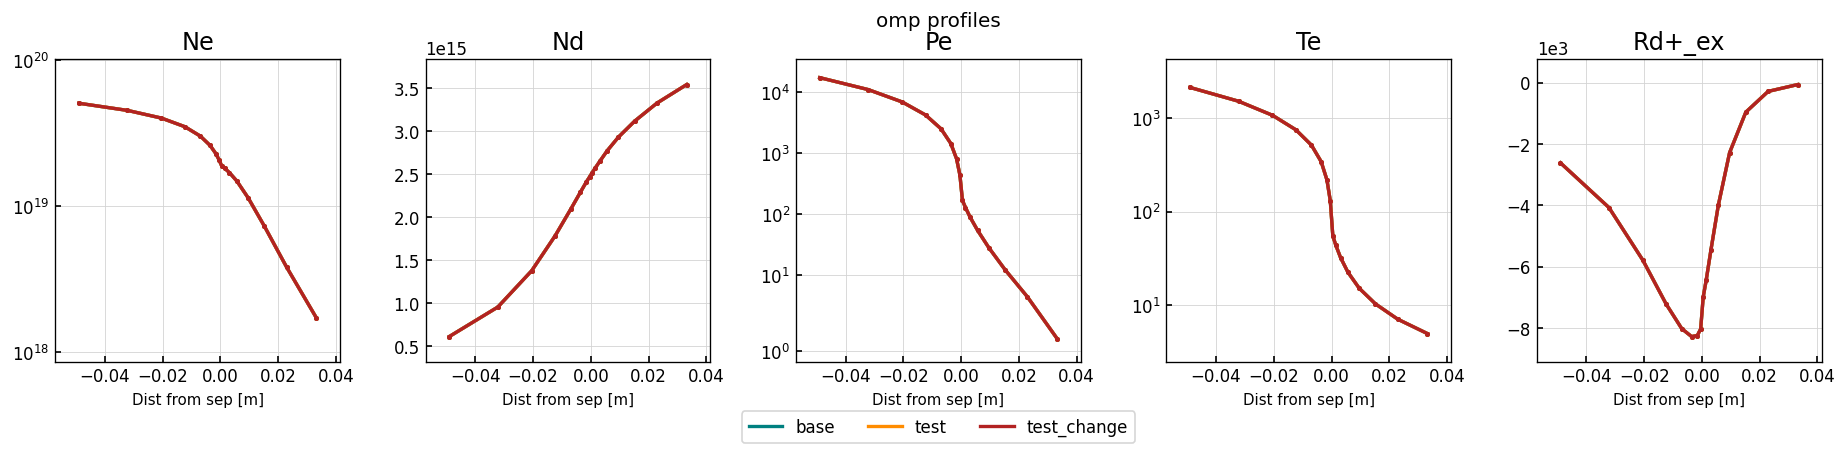

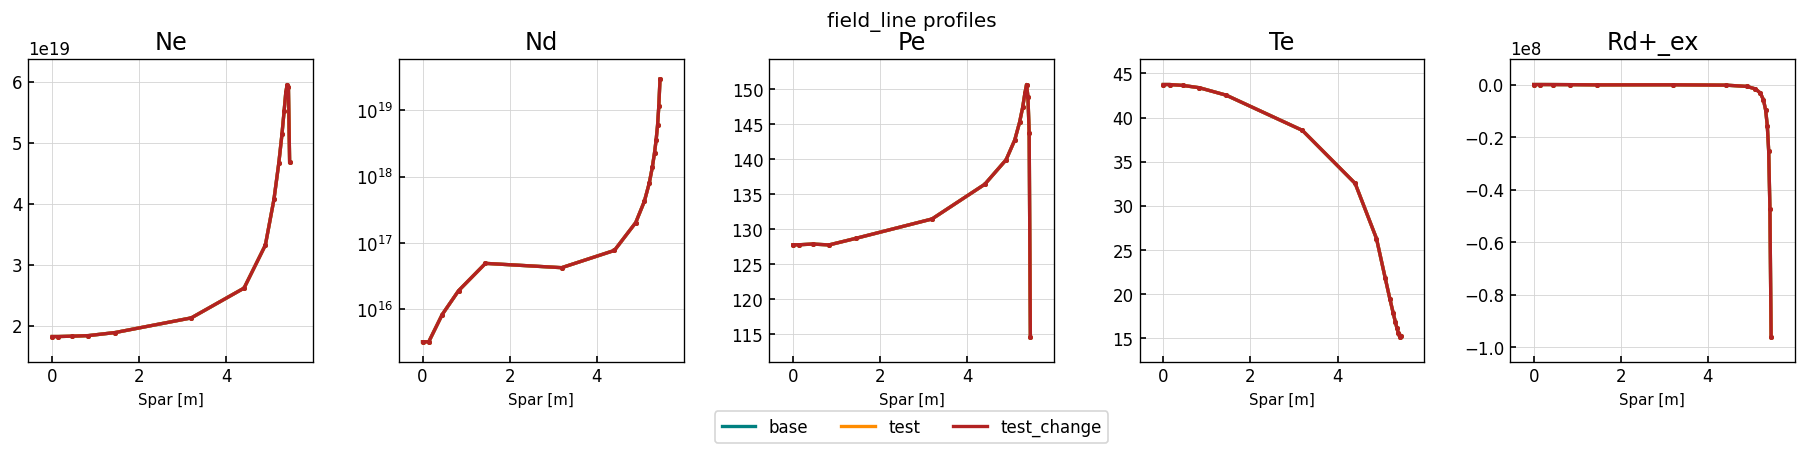

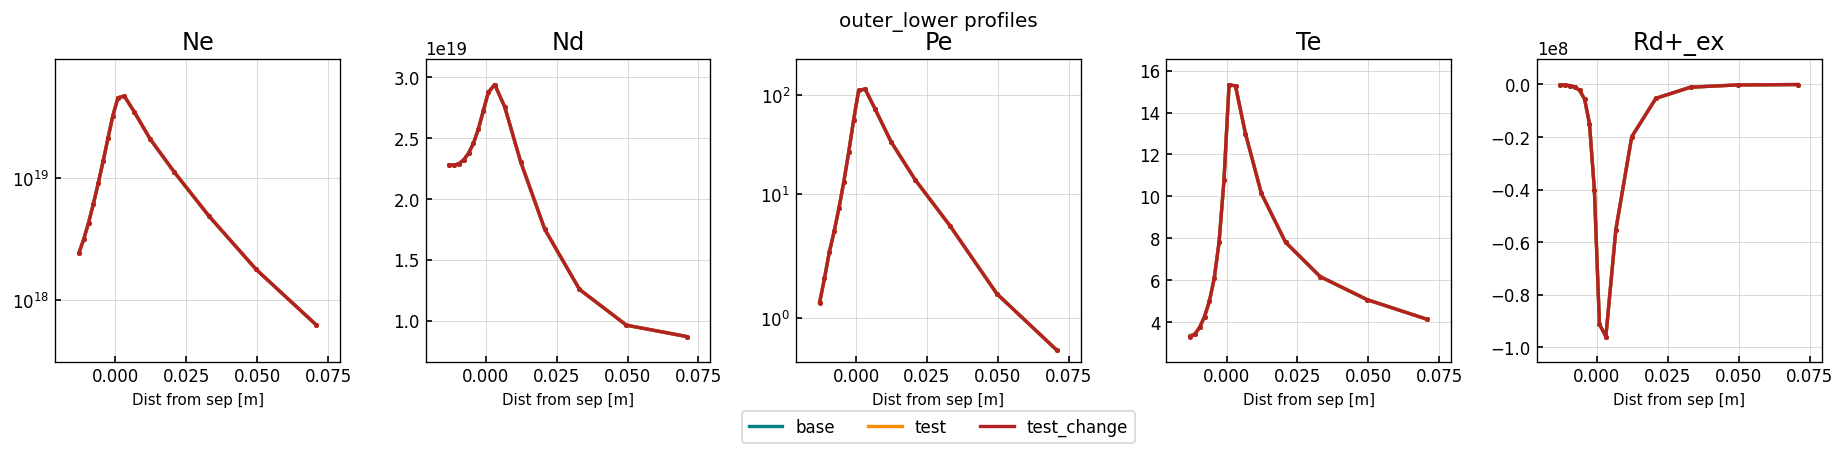

In [5]:
toplot = {}

for case in cs:
    toplot[case] = cs[case].ds.isel(t=-1)
    
lineplot(
    toplot,
    params = ["Ne", "Nd", "Pe","Te", "Rd+_ex"],
    regions = ["omp", "field_line", "outer_lower"],
)